# Example 2: Visualizing the Haxby (fMRI) dataset with `kmapper` + `dyneusr` #


## 1 &nbsp;  `import` libraries ##

In [10]:
# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import os

In [12]:
import numpy as np
import pandas as pd
import scipy as sp

import networkx as nx
from collections import Counter

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set("paper", "white")

%matplotlib inline

### 1.1 &nbsp;  `import kmapper` ###

Here, we will use the KeplerMapper (`kmapper`) implementation of the Mapper algorithm. 

We will also import sklearn implementations of PCA and TSNE to use as (linear and non-linear) filter functions for Mapper.

In [14]:
import kmapper as km
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA 

### 1.2 &nbsp;  `import dyneusr` ###

Note, `dyneusr` provides a wrapper around `kmapper` with support for caching each step of the Mapper algorithm. This will speed things up, especially when generating several shape graphs for different subjects. For a more detailed walk-through of how to generate a shape graph using `kmapper`, see `01_trefoil_knot/01_trefoil_knot.ipynb`. 

In [15]:
import dyneusr as ds

# kmapper wrappers
from dyneusr.mapper.wrappers import KMapperWrapper
from dyneusr.mapper.utils import optimize_cover, optimize_dbscan

## 2 &nbsp; Load `data` ##

In [16]:
from load_data import load_haxby, Bunch

Here, we actually use `nilearn.datasets.fetch_haxby` to fetch the files for the Haxby dataset. To make this note book more readable, we wrapped several steps into a single `load_haxby` function, stored in `load_data.py`. 

These steps include: 
1. fetching the Haxby dataset files; 
2. performing some preprocessing; and
3. storing the data for each subject as an `sklearn.datasets.base.Bunch` object for easy access. 

A list of these objects, one for each subject, is stored in a higher-level object, which also stores some other important meta-data shared across subjects. This higher-level object is returned by the function, `load_haxby`.

In [17]:
# load data for all 6 subjects, but only sessions 4-5
haxby = load_haxby(subjects=-1, sessions=[4,5], targets=None)

# extract subjects, print some information about them
subjects = haxby.subjects
for i, subject in enumerate(subjects):
    print(i, subject.name, subject.data.shape, subject.target.shape)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1

0 subj1_sess4_5 (242, 577) (242, 9)
1 subj2_sess4_5 (242, 577) (242, 9)
2 subj3_sess4_5 (242, 577) (242, 9)
3 subj4_sess4_5 (242, 577) (242, 9)
4 subj5_sess4_5 (242, 577) (242, 9)
5 subj6_sess4_5 (242, 577) (242, 9)


### 2.1 &nbsp; Visualize the `data` ###

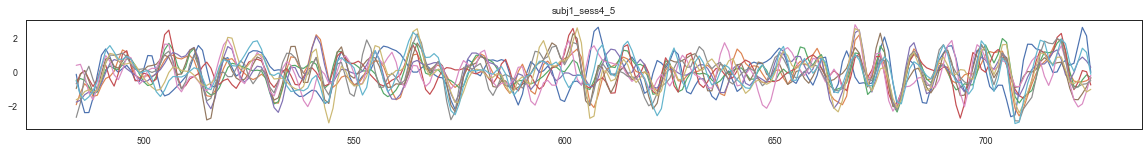

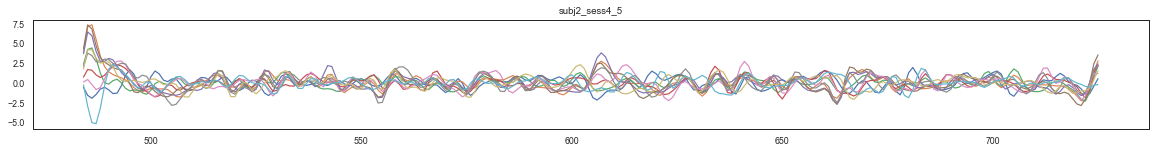

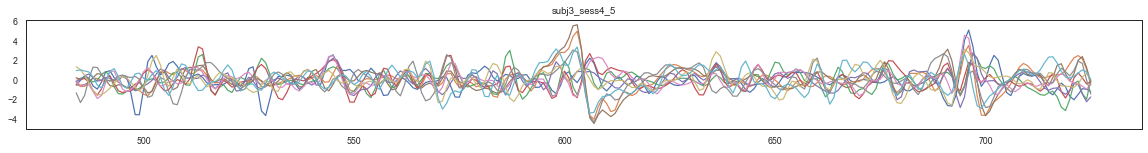

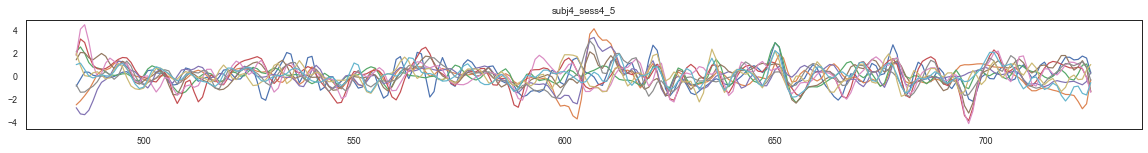

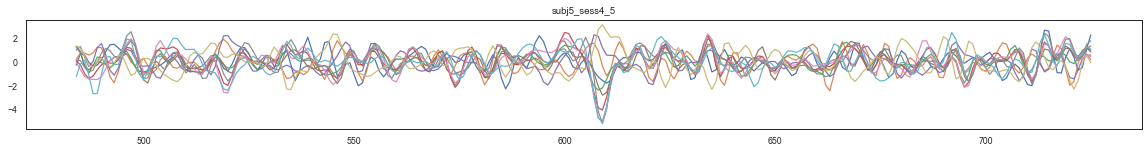

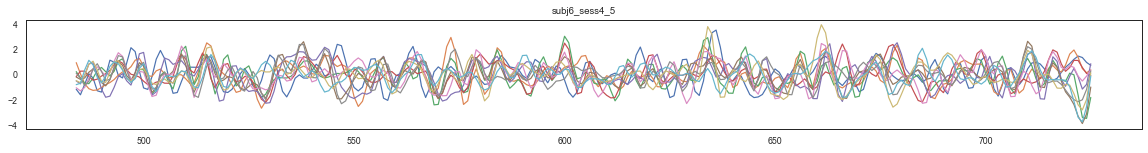

In [18]:
# inspect the first 10 voxels
for subject in haxby.subjects:
    _ = subject.data.iloc[:,:10].plot(
        figsize=(20,2), 
        legend=False, 
        title=subject.name
        )

### 2.2 &nbsp; Visualize the `meta` data ###

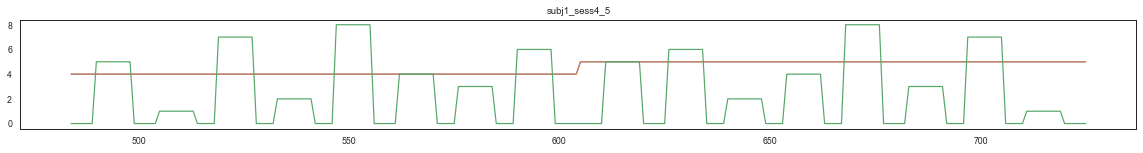

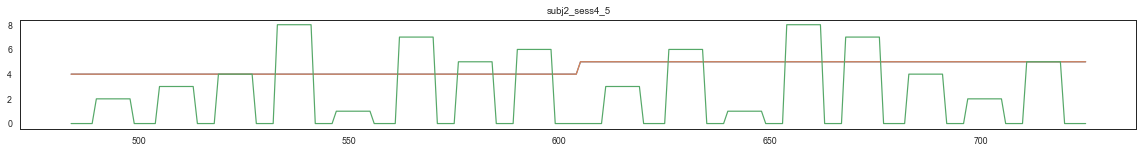

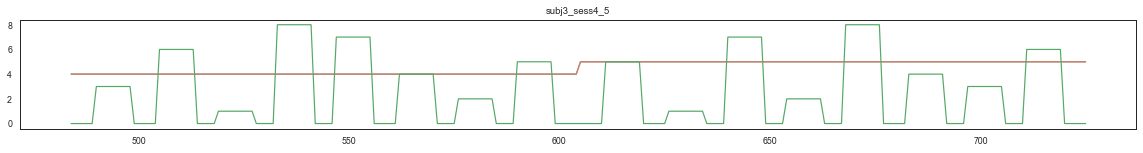

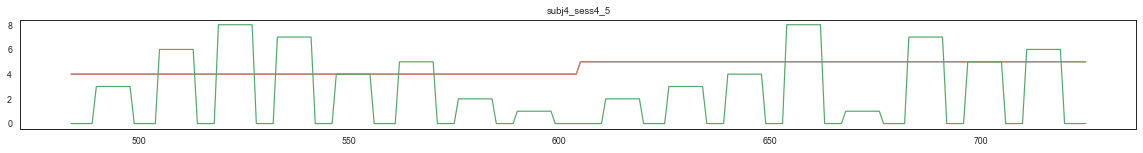

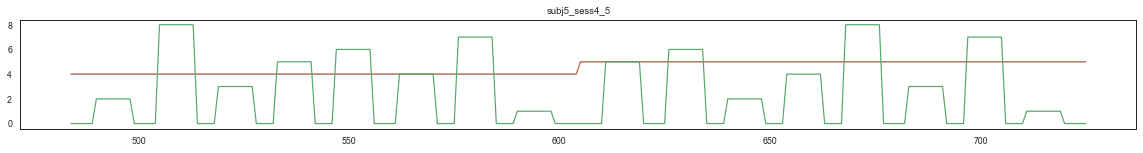

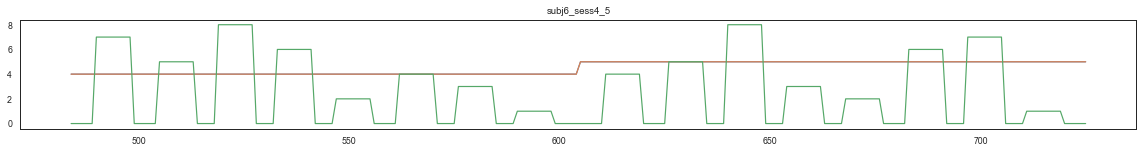

In [19]:
# inspect the first 10 voxels
for subject in haxby.subjects:
    _ = subject.meta.iloc[:,:10].plot(
        figsize=(20,2), 
        legend=False, 
        title=subject.name
        )


## 3 &nbsp; Generate a shape graph for each subject with `kmapper` ##

In [35]:
import numpy as np 
import pandas as pd

from nilearn.datasets import fetch_haxby
from nilearn.input_data import NiftiMasker

from dyneusr import DyNeuGraph
from kmapper import KeplerMapper, Cover
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

# Fetch dataset, extract time-series from ventral temporal (VT) mask
dataset = fetch_haxby()
masker = NiftiMasker(
    dataset.mask_vt[0], 
    standardize=True, detrend=True, smoothing_fwhm=4.0,
    low_pass=0.09, high_pass=0.008, t_r=2.5,
    memory="nilearn_cache")
X = masker.fit_transform(dataset.func[0])

# Encode labels as integers
df = pd.read_csv(dataset.session_target[0], sep=" ")
target, labels = pd.factorize(df.labels.values)
y = pd.DataFrame({l:(target==i).astype(int) for i,l in enumerate(labels)})

# Generate shape graph using KeplerMapper
mapper = KeplerMapper(verbose=1)
lens = mapper.fit_transform(X, projection=TSNE(2))
graph = mapper.map(lens, X, cover=Cover(20, 0.5), clusterer=DBSCAN(eps=20.))

# Visualize the shape graph using DyNeuSR's DyNeuGraph                          
dG = DyNeuGraph(G=graph, y=y)
dG.visualize('dyneusr_output.html')

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: TSNE()
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1452, 464)

..Projecting data using: 
	TSNE(verbose=1)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1452 samples in 0.000s...
[t-SNE] Computed neighbors for 1452 samples in 0.044s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1452
[t-SNE] Computed conditional probabilities for sample 1452 / 1452
[t-SNE] Mean sigma: 8.407335
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.128357
[t-SNE] KL divergence after 1000 iterations: 1.568427

..Scaling with: MinMaxScaler()

Mapping on data shaped (1452, 464) using lens shaped (1452, 2)

Creating 400 hypercubes.

Created 613 edges and 202 nodes in 0:00:00.167146.


label,group,value,row_count
rest,0,588,1452
scissors,1,108,1452
face,2,108,1452
cat,3,108,1452
shoe,4,108,1452
house,5,108,1452
scrambledpix,6,108,1452
bottle,7,108,1452
chair,8,108,1452


   > Found 0 nodes for data point 1.
   > Found 0 nodes for data point 2.
   > Found 0 nodes for data point 3.
   > Found 0 nodes for data point 4.
   > Found 0 nodes for data point 5.
   > Found 0 nodes for data point 6.
   > Found 0 nodes for data point 7.
   > Found 0 nodes for data point 72.
   > Found 0 nodes for data point 73.
   > Found 0 nodes for data point 74.
   > Found 0 nodes for data point 76.
   > Found 0 nodes for data point 84.
   > Found 0 nodes for data point 93.
   > Found 0 nodes for data point 94.
   > Found 0 nodes for data point 95.
   > Found 0 nodes for data point 113.
   > Found 0 nodes for data point 114.
   > Found 0 nodes for data point 115.
   > Found 0 nodes for data point 121.
   > Found 0 nodes for data point 122.
   > Found 0 nodes for data point 123.
   > Found 0 nodes for data point 124.
   > Found 0 nodes for data point 125.
   > Found 0 nodes for data point 226.
   > Found 0 nodes for data point 233.
   > Found 0 nodes for data point 234.
   > Fou

   > Found 0 nodes for data point 1176.
   > Found 0 nodes for data point 1203.
   > Found 0 nodes for data point 1204.
   > Found 0 nodes for data point 1205.
   > Found 0 nodes for data point 1206.
   > Found 0 nodes for data point 1207.
   > Found 0 nodes for data point 1208.
   > Found 0 nodes for data point 1209.
   > Found 0 nodes for data point 1210.
   > Found 0 nodes for data point 1211.
   > Found 0 nodes for data point 1212.
   > Found 0 nodes for data point 1213.
   > Found 0 nodes for data point 1214.
   > Found 0 nodes for data point 1215.
   > Found 0 nodes for data point 1216.
   > Found 0 nodes for data point 1217.
   > Found 0 nodes for data point 1218.
   > Found 0 nodes for data point 1219.
   > Found 0 nodes for data point 1220.
   > Found 0 nodes for data point 1221.
   > Found 0 nodes for data point 1227.
   > Found 0 nodes for data point 1228.
   > Found 0 nodes for data point 1229.
   > Found 0 nodes for data point 1230.
   > Found 0 nodes for data point 1231.


DyNeuGraph()